# Machine Learning Demonstrations - 6

To run these notebooks, you need to install python dependencies:

With pip:

```pip install numpy==1.14.0
pip install pandas=0.20.3
pip install matplotlib==2.0.2
pip install scikit_learn==0.19.1
pip install xgboost==0.7.post```


## Classification using Random Forests

The Random Forest algorithm is an ensemble learning method, used for supervised classification and regression problems.  
Random Forests combine multiple decision trees and output an average prediction.

Random Forests can
- Manage a mixture of discrete, continuous and categorical inputs
- Use data with no normalization/pre-processing (including missing data)
- Incorporate a large number of trees without overfitting

They are, therefore, the preferred machine learning algorithm in many applications (even over neural networks).

A Random Forest is a collection (often large) of decision trees, each fitted to a subset of the data. A standard choice for subset is to randomly choose 50% of the datapoints (rows) and  p⎯⎯√p  of the  pp  features (columns). A decision tree is fitted to each subset until the desired number of trees have been *grown* in the random forest. 

The technique, of fitting weakly-predictive models to subsets of the data, is called *bagging* (bootstrap aggregation).

Further discussion of Random Forests can be found on the [Wikipedia article](https://en.wikipedia.org/wiki/Random_forest) or [Sci-Kit Learn documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). 

## Santander Customer Satisfaction Data

The Santander Customer Satisfaction dataset (from Kaggle) is a database of 76,020 customers of Santander bank.  
There are 370 features for each customer, along with a field indicating whether they were satisfied customers of the bank or not.

### Load data

In [1]:
/ Utility functions
\l ../utils/funcs.q
\l ../utils/graphics.q

In [2]:
show 5#data:((370#"F"),"I";(),",")0:`:../data/santander.csv
/ Inspect data
-1"\nShape of feature data is: ",-3!shape delete TARGET from data;
-1"\nDistribution of target values is:\n";
show update pcnt:.01*floor .5+10000*num%sum num from select num:count i by TARGET from data;

ID var3 var15 imp_ent_var16_ult1 imp_op_var39_comer_ult1 imp_op_var39_comer_u..
-----------------------------------------------------------------------------..
1  2    23    0                  0                       0                   ..
3  2    34    0                  0                       0                   ..
4  2    23    0                  0                       0                   ..
8  2    37    0                  195                     195                 ..
10 2    39    0                  0                       0                   ..

Shape of feature data is: 76020 370

Distribution of target values is:

TARGET| num   pcnt 
------| -----------
0     | 73012 96.04
1     | 3008  3.96 


Classes are highly unbalanced
- 96% are satisfied
- 4% of clients are dissatisfied

A predictor that naively predicted that all clients were satisfied, would therefore achieve nearly 96% accuracy on this dataset. However, such a model would not be of much use in predicting customer churn.

### Split data
67/33 training/test split

In [3]:
\S 123 / random seed
show count each datadict:traintestsplit[flip value flip delete TARGET from data;data.TARGET;0.33];

xtrain| 50933
ytrain| 50933
xtest | 25087
ytest | 25087


### Evaluation function
Function to create, fit and evaluate classifiers

In [4]:
scoreresults:{[yact;ypred;yprob]
 `loss`acc`auc!(logloss;accuracy;rocaucscore).'(yact;)each(yprob;ypred;yprob[;1])}

results:{[classifier;name;classifierkwargs;ntrees]
    xnp:nparray datadict.xtrain;
    ynp:datadict.ytrain;
    rf:classifier[`n_estimators pykw ntrees;pykwargs classifierkwargs];
    rf[`:fit][xnp;ynp]; 
    
    ytrainprob:rf[`:predict_proba;<;xnp];
    ytrainpred:raze {x?max x}each ytrainprob;
    ytestprob:rf[`:predict_proba;<;nparray datadict.xtest];
    ytestpred:raze {x?max x}each ytestprob;
  
//    .j.DEB:(datadict.ytrain;ytrainprob);
    trainscore:scoreresults[datadict.ytrain;ytrainpred;ytrainprob];
    testscore:scoreresults[datadict.ytest;ytestpred;ytestprob];
    
    -1(name)," (",(string ntrees)," trees)";
    -1"Training - log loss : ",(string trainscore`loss),", accuracy: ",(raze string trainscore`acc),", ROC: ",string trainscore`auc;
    -1"Testing - log loss : ",(string testscore`loss),", accuracy: ",(raze string testscore`acc),", ROC: ",string testscore`auc;
    -1"\n";
 }

### Fit and Evaluate models
Fit Random Forest classifiers on the training data, and evaluate their performance on the held-out test data.  
Evaluate random forests with 1, 5, 10, 50 and 100 trees.

In [5]:
RFClassifier:.p.import[`sklearn.ensemble]`:RandomForestClassifier
ntrees:1 5 10 50 100
rfkwargs:enlist[`class_weight]!enlist`balanced
results[RFClassifier;"Random Forest Classifier";rfkwargs;]each ntrees;

Random Forest Classifier (1 trees)
Training - log loss : 0.8659615, accuracy: 0.9749278, ROC: 0.8308313
Testing - log loss : 2.420344, accuracy: 0.9299239, ROC: 0.5426806


Random Forest Classifier (5 trees)
Training - log loss : 0.03867462, accuracy: 0.9911845, ROC: 0.9954468
Testing - log loss : 0.910391, accuracy: 0.9523259, ROC: 0.6391919


Random Forest Classifier (10 trees)
Training - log loss : 0.02996604, accuracy: 0.9916557, ROC: 0.9998337
Testing - log loss : 0.6966164, accuracy: 0.9573484, ROC: 0.686615


Random Forest Classifier (50 trees)
Training - log loss : 0.02829401, accuracy: 0.9993521, ROC: 0.9999898
Testing - log loss : 0.336988, accuracy: 0.9584645, ROC: 0.771155


Random Forest Classifier (100 trees)
Training - log loss : 0.02822416, accuracy: 0.9999018, ROC: 0.9999898
Testing - log loss : 0.2644978, accuracy: 0.9581457, ROC: 0.7823051




Accuracy is significantly better on the training data than the test data. Near-perfect accuracy suggests that the model has effectively _memorized_ the training dataset. The goal of the model is to generalize to unseen datasets, so we must be wary of *overfitting* the model.

Receiver Operating Characteristic (ROC) describes the ability to increase the recall/sensitivity of a model, without decreasing the precision of the model. The ROC value is calulated as the area under the associated ROC curve (plotting true positive rates against false positive rates).

We can look at the ROC curve (for 100 trees)

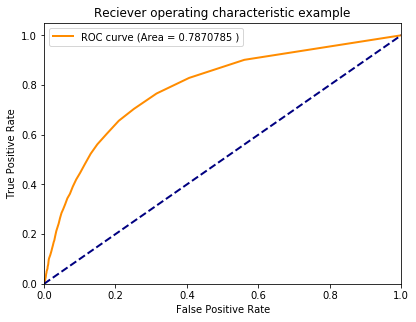

In [6]:
classifier:RFClassifier[`n_estimators pykw 100;`class_weight pykw`balanced];

classifier[`:fit][datadict.xtrain;datadict.ytrain];
ytestprob:classifier[`:predict_proba;<]datadict.xtest

displayROCcurve[datadict.ytest;ytestprob[;1]];

Overfitting can be controled by reducing the degree of freedom of the model, such as the depth of the trees that the algorithm constructs.  
We therefore repeat the exercise as previously, restricting the tree depth to 4.

In [7]:
rfkwargs:`class_weight`max_depth!(`balanced;4)
results[RFClassifier;"Random Forest Classifier";rfkwargs;]each ntrees;

Random Forest Classifier (1 trees)
Training - log loss : 0.597343, accuracy: 0.6447097, ROC: 0.7203665
Testing - log loss : 0.6019317, accuracy: 0.6415275, ROC: 0.7085452


Random Forest Classifier (5 trees)
Training - log loss : 0.5749564, accuracy: 0.7307247, ROC: 0.7892263
Testing - log loss : 0.5761435, accuracy: 0.7298999, ROC: 0.782161


Random Forest Classifier (10 trees)
Training - log loss : 0.5539985, accuracy: 0.7593702, ROC: 0.7981632
Testing - log loss : 0.5554814, accuracy: 0.7584805, ROC: 0.7936706


Random Forest Classifier (50 trees)
Training - log loss : 0.5707365, accuracy: 0.7213398, ROC: 0.8037277
Testing - log loss : 0.5725831, accuracy: 0.71838, ROC: 0.7959746


Random Forest Classifier (100 trees)
Training - log loss : 0.5678716, accuracy: 0.7232835, ROC: 0.8026218
Testing - log loss : 0.5694235, accuracy: 0.7210507, ROC: 0.7959156




Overfitting is certainly eliminated by restricting the tree depth.

Looking at the test results
- The ROC measure is comparable to previous classifiers
- The accuracy has reduced

Looking at the ROC curve (for 100 trees)

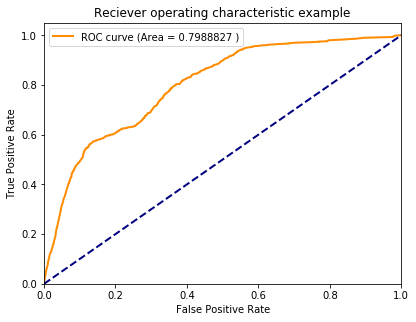

In [8]:
classifier:RFClassifier[`n_estimators pykw 100;`max_depth pykw 4;`class_weight pykw`balanced];

classifier[`:fit][datadict.xtrain;datadict.ytrain];
ytestprob:classifier[`:predict_proba;<]datadict.xtest

displayROCcurve[datadict.ytest;ytestprob[;1]];

### XGBoost

XGBoost is a Random Forest algorithm that combines the *bagging* technique with a further addition, called *boosting*.

Boosting works by increasing the weighting on examples that have been misclassified in the past.

The XGBoost algorithm also allows significantly more control over the bagging procedure than SKLearn's default Random Forest classifier does (SKLearn's default RF algorithm allows only 100% sampling with replacement of the training data - XGBoost allows control over the % of the training set that is sampled for individual trees, and whether this sampling is done with replacement, or not).

Further information can be found on the [XGBoost website](https://xgboost.readthedocs.io/en/latest/).

### Fit and Evaluate models

In [9]:
XGB:.p.import[`xgboost]`:XGBClassifier
rfkwargs:enlist[`max_depth]!enlist 4
results[XGB;"XGB Classifier";rfkwargs;]each ntrees;

XGB Classifier (1 trees)
Training - log loss : 0.611427, accuracy: 0.9606346, ROC: 0.8116304
Testing - log loss : 0.6116487, accuracy: 0.9600191, ROC: 0.8063202


XGB Classifier (5 trees)
Training - log loss : 0.4023638, accuracy: 0.9606346, ROC: 0.8249033
Testing - log loss : 0.4031678, accuracy: 0.9600191, ROC: 0.8195953


XGB Classifier (10 trees)
Training - log loss : 0.2724433, accuracy: 0.9606346, ROC: 0.8291078
Testing - log loss : 0.2737375, accuracy: 0.9600191, ROC: 0.8220217


XGB Classifier (50 trees)
Training - log loss : 0.1310289, accuracy: 0.9606542, ROC: 0.8576592
Testing - log loss : 0.1357843, accuracy: 0.9600191, ROC: 0.841999


XGB Classifier (100 trees)
Training - log loss : 0.1253647, accuracy: 0.9609487, ROC: 0.8737437
Testing - log loss : 0.1347302, accuracy: 0.960059, ROC: 0.842185




These results show a significant improvement, in both accuracy and ROC scores.

Looking at the ROC curve (for 100 trees)

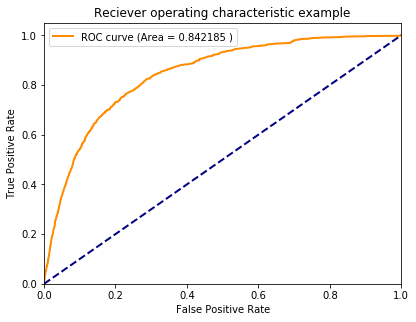

In [10]:
classifier:XGB[`n_estimators pykw 100;`max_depth pykw 4];
classifier[`:fit][nparray datadict.xtrain;nparray datadict.ytrain];

ytestprob:classifier[`:predict_proba;<]nparray datadict.xtest

displayROCcurve[datadict.ytest;ytestprob[;1]];

The classifier with 100 trees attains a ROC of 0.85. This is equal to the highest result recorded in Kaggle for this dataset.